In [2]:
!pip install pandas numpy matplotlib yfinance

In [62]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler


In [77]:
# %%
# Download data
symbol = "GC=F"
df = yf.download(symbol, start="2015-01-01", interval = '1wk')
df = df.dropna()

# Flatten columns
df.columns = ['_'.join(col).strip() for col in df.columns.values]
print(df.columns)

/tmp/ipython-input-2076899254.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2015-01-01", interval = '1wk')
[*********************100%***********************]  1 of 1 completed


Index(['Close_GC=F', 'High_GC=F', 'Low_GC=F', 'Open_GC=F', 'Volume_GC=F'], dtype='object')


In [78]:
df.columns

Index(['Close_GC=F', 'High_GC=F', 'Low_GC=F', 'Open_GC=F', 'Volume_GC=F'], dtype='object')

In [81]:
df.rename(columns={
    'Open_GC=F': 'Open',
    'High_GC=F': 'High',
    'Low_GC=F': 'Low',
    'Close_GC=F': 'Close',
    'Volume_GC=F': 'Volume'
}, inplace=True)

In [82]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [83]:
# %%
# Create features
# Simple: daily return


df['ret'] = df['Close'].pct_change()
df['vol'] = (df['High'] - df['Low']) / df['Open']
df = df.dropna()

FEATURES = ['ret', 'vol']
X = df[FEATURES].values


# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [84]:
# %%
# Lorentzian distance
def lorentzian_distance(x, y):
  return np.sum(np.log1p(np.abs(x - y)))

# Compute distance from each point to mean (centroid)
centroid = X_scaled.mean(axis=0)
distances = np.array([lorentzian_distance(x, centroid) for x in X_scaled])

In [100]:
# %%
# Detect anomalies: points far from centroid
threshold = distances.mean() + 2 * distances.std()
anomalies = distances > threshold


df['lorentz_dist'] = distances
df['anomaly'] = anomalies.astype(int)




/tmp/ipython-input-1621129416.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lorentz_dist'] = distances
/tmp/ipython-input-1621129416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = anomalies.astype(int)


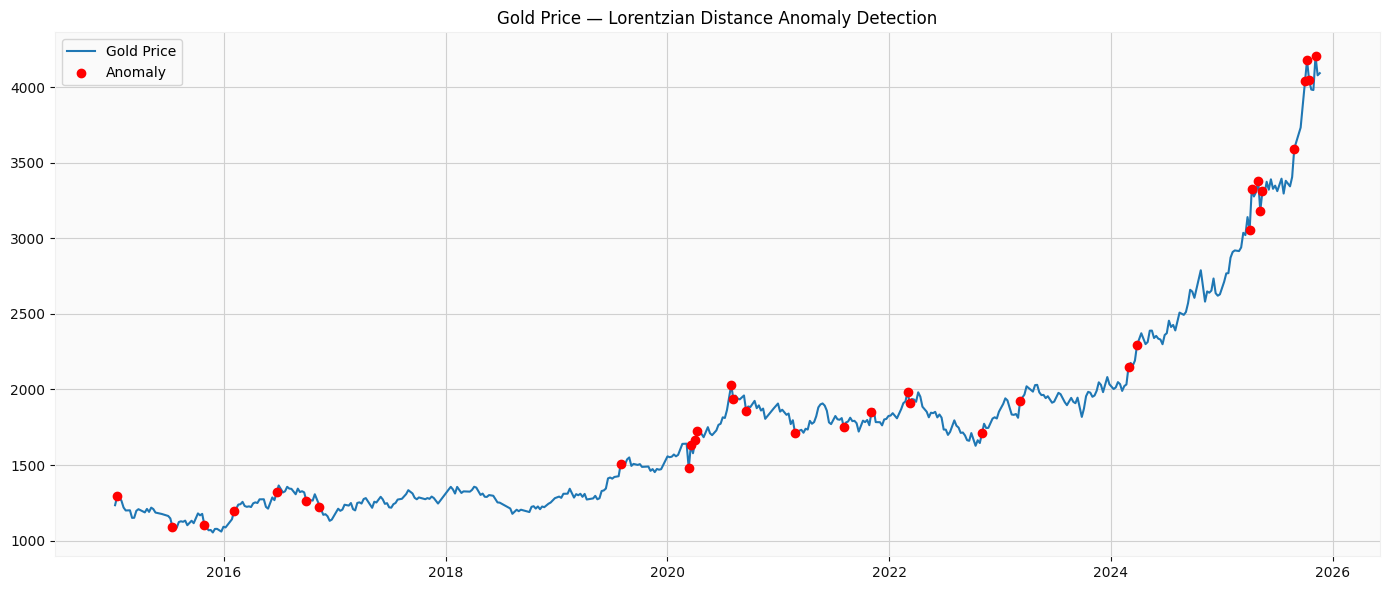

In [101]:
# %%
# Plot
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label='Gold Price')
plt.scatter(df.index[df['anomaly']==1], df['Close'][df['anomaly']==1], color='red', label='Anomaly', zorder=5)
plt.title('Gold Price — Lorentzian Distance Anomaly Detection')
plt.legend()
plt.tight_layout()
plt.show()

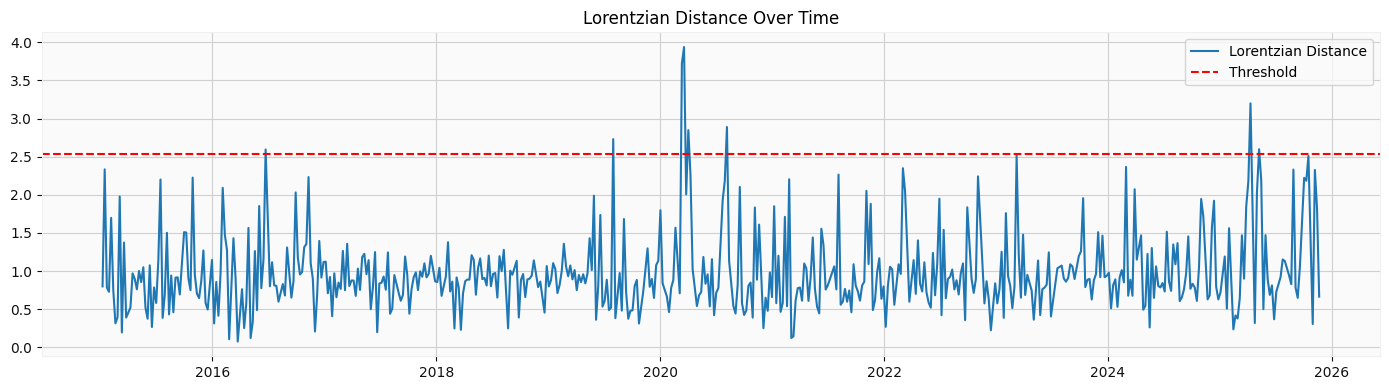

In [99]:

# %%
# Plot Lorentzian distances
plt.figure(figsize=(14,4))
plt.plot(df.index, df['lorentz_dist'], label='Lorentzian Distance')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Lorentzian Distance Over Time')
plt.legend()
plt.tight_layout()
plt.show()